<a href="https://colab.research.google.com/github/Smitm06/Simulation-of-a-2R-Elbow-Manipulator/blob/main/Miniproject1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TASK 1 (Without dynamics)**




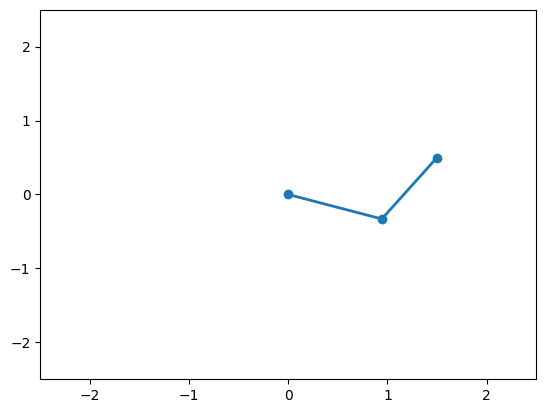

In [ ]:



import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Define the robot's link lengths
L1 = 1.0
L2 = 1.0

# Function to compute forward kinematics
def forward_kinematics(theta1, theta2):
    x = L1 * np.cos(theta1) + L2 * np.cos(theta1 + theta2)
    y = L1 * np.sin(theta1) + L2 * np.sin(theta1 + theta2)
    return x, y

# Function to compute inverse kinematics
def inverse_kinematics(x, y):
    # Compute D and limit it to the valid range [-1, 1]
    D = (x**2 + y**2 - L1**2 - L2**2) / (2 * L1 * L2)
    D = np.clip(D, -1, 1)

    # Calculate theta2 using the clipped D value
    theta2 = np.arctan2(np.sqrt(1 - D**2), D)

    # Calculate theta1 based on the clipped D value
    theta1 = np.arctan2(y, x) - np.arctan2(L2 * np.sin(theta2), L1 + L2 * np.cos(theta2))
    return theta1, theta2

# Create a figure and axis for visualization
fig, ax = plt.subplots()
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)

# Desired end-tip position
desired_x = 1.5
desired_y = 0.5

# Initialize the robot at the initial position (both links resting on the x-axis)
theta1_current = 0.0
theta2_current = 0.0

# Plot the robot arm
line, = ax.plot([], [], 'o-', lw=2)

# Update function for animation
def update(frame):
    global theta1_current, theta2_current

    # Compute joint angles using inverse kinematics
    theta1_target, theta2_target = inverse_kinematics(desired_x, desired_y)

    # Interpolate joint angles for smoother motion (adjust speed as needed)
    theta1_current += 0.1 * (theta1_target - theta1_current)
    theta2_current += 0.1 * (theta2_target - theta2_current)

    # Compute end-tip position using forward kinematics
    x, y = forward_kinematics(theta1_current, theta2_current)

    # Update the robot arm's line data
    line.set_data([0, L1 * np.cos(theta1_current), x], [0, L1 * np.sin(theta1_current), y])

    return line,

# Create an animation
ani = FuncAnimation(fig, update, frames=100, interval=100, blit=True)

# Display the animation in the Colab notebook
HTML(ani.to_jshtml())


TASK 1 (With dynamics)

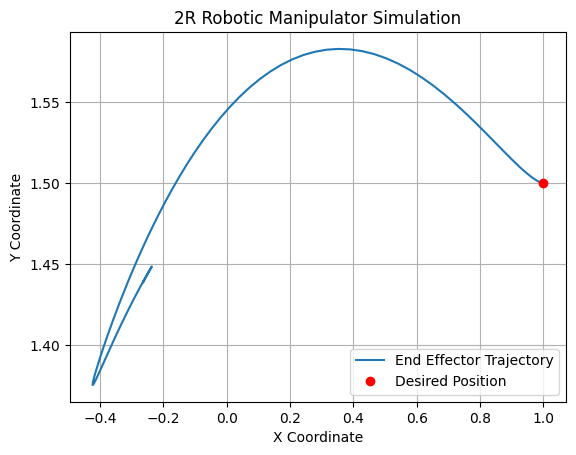

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

L1 = 1.0
L2 = 1.0
mass = 1.0
I = 0.1

Kp = 100.0
Kd = 20.0

initial_state = [0.0, 0.0, 0.0, 0.0] #[theta1, theta2, theta1_dot, theta2_dot]

def dynamics(state, t, torque1, torque2):
    theta1, theta2, theta1_dot, theta2_dot = state
    M = np.array([[L1**2 + L2**2 + (I + mass*L1**2), L2*(L2 + I)], [L2*(L2 + I), L2**2 + I]])
    C = np.array([[0, -L2*theta2_dot], [0, 0]])
    N = np.array([0, 0])
    q_ddot = np.linalg.solve(M, np.array([torque1 - C[0, 1]*theta2_dot - N[0], torque2 - C[1, 1]*theta2_dot - N[1]]))
    return [theta1_dot, theta2_dot, q_ddot[0], q_ddot[1]]

def inverse_kinematics(x, y):
    theta2 = np.arccos((x**2 + y**2 - L1**2 - L2**2) / (2 * L1 * L2))
    theta1 = np.arctan2(y, x) - np.arctan2(L2 * np.sin(theta2), L1 + L2 * np.cos(theta2))
    return theta1, theta2

def control(state, desired_state):
    error = np.array(desired_state[:2]) - np.array(state[:2])
    error_dot = np.array(desired_state[2:]) - np.array(state[2:])
    torque1 = Kp * error[0] + Kd * error_dot[0]
    torque2 = Kp * error[1] + Kd * error_dot[1]
    return torque1, torque2

t = np.linspace(0, 10, 1000)
desired_position = [1.0, 1.5]

theta1_initial, theta2_initial = inverse_kinematics(*desired_position)
initial_state[:2] = theta1_initial, theta2_initial

desired_state = np.concatenate((np.array(desired_position), np.zeros(2)))

states = []
current_state = np.array(initial_state)
for i in range(len(t) - 1):
    torque1, torque2 = control(current_state, desired_state)
    next_state = odeint(dynamics, current_state, [t[i], t[i+1]], args=(torque1, torque2))
    current_state = next_state[-1]
    states.append(current_state)

states = np.array(states)
theta1 = states[:, 0]
theta2 = states[:, 1]

x_traj = L1 * np.cos(theta1) + L2 * np.cos(theta1 + theta2)
y_traj = L1 * np.sin(theta1) + L2 * np.sin(theta1 + theta2)

plt.figure()
plt.plot(x_traj, y_traj, label='End Effector Trajectory')
plt.plot(desired_position[0], desired_position[1], 'ro', label='Desired Position')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('2R Robotic Manipulator Simulation')
plt.legend()
plt.grid()
plt.show()

TASK 2


The Normal is  =  5.0
Torque 1 =  4.30144173030723
Torque 2 =  0.6985582696927697


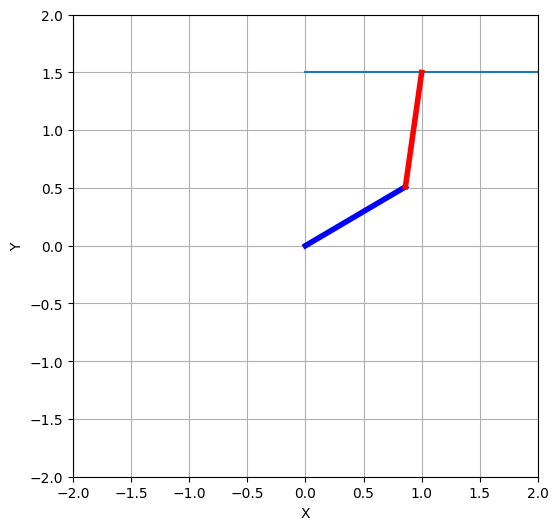

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Defining constants for the 2R manipulator
l1 = 1.0
l2 = 1.0
N = 5.0 #Normal force from the wall

#wall
xp = 2
yp = 1.5
xq = 0
yq = 1.5
m = np.arctan((yp - yq)/(xp - xq))
i = [xp, xq]
j = [yp, yq]

# Inverse kinematics function to calculate joint angles from x and y
def inverse_kinematics(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arccos((x**2 + y**2 - l1**2 - l2**2) / (2 * l1 * l2))
    alpha = np.arctan2(y, x)
    beta = np.arctan2(l2 * np.sin(phi), l1 + l2 * np.cos(phi))
    theta1 = alpha - beta
    theta2 = theta1 + phi
    return theta1, theta2


x_initial, y_initial = 0.0, 0.0  # Starting location
x_final, y_final = 1, 1.5   # Target location

theta1_desired, theta2_desired = inverse_kinematics(x_final, y_final)

# Theta array
num_steps = 100
t_max = 1
theta1_r = np.linspace(0, theta1_desired , num_steps)
theta2_r = np.linspace(0, theta2_desired , num_steps)

# Create animation
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.plot(i, j, label='wall')  # Plot the wall line

link_1, = ax.plot([], [], 'b-', lw=4)
link_2, = ax.plot([], [], 'r-', lw=4)

def init():
    link_1.set_data([], [])
    link_2.set_data([], [])
    return link_1, link_2

def animate(i, ax):

    x_final = l1 * np.cos(theta1_r[i])
    y_final = l1 * np.sin(theta1_r[i])
    x2 = x_final + l2 * np.cos(theta2_r[i])
    y2 = y_final + l2 * np.sin(theta2_r[i])

    link_1.set_data([0, x_final], [0, y_final])
    link_2.set_data([x_final, x2], [y_final, y2])

    return link_1, link_2

ani = FuncAnimation(fig, animate, fargs=(ax,), frames=num_steps, init_func=init, blit=True, interval=(t_max / num_steps) * 1000)

plt.xlabel('X')
plt.ylabel('Y')

plt.grid()

# Calculating normals
N_x = N * np.sin(m)
N_y = N * np.cos(m)
Norm = np.array([[N_x],[N_y]])

# Jacobian matrix
Jt = np.array([[(-l1 * np.sin(theta1_desired)), (l1 * np.cos(theta1_desired))],
              [(-l2 * np.sin(theta2_desired)), (l2 * np.cos(theta2_desired))]])

# Calculating torques
T = np.dot(Jt, Norm)

print('The Normal is  = ', N)
print('Torque 1 = ', T[0,0])
print('Torque 2 = ', T[1,0])


from IPython.display import HTML
HTML(ani.to_jshtml())

TASK 4:

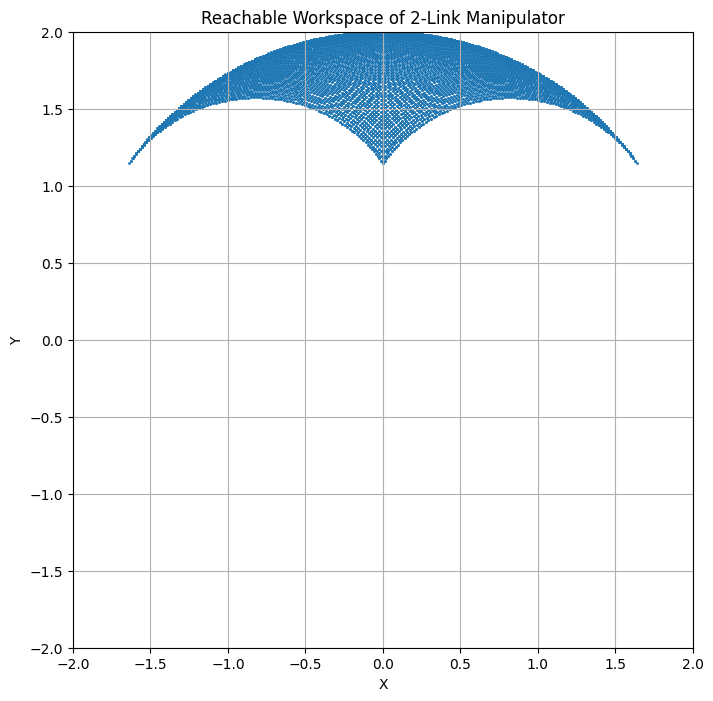

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants for a 2-link manipulator
link_length1 = 1.0  # Length of the first link (meters)
link_length2 = 1.0  # Length of the second link (meters)

# Define the range of joint angles (in radians)
joint_angle_range = np.deg2rad(np.linspace(35, 145, 100))
workspace_coordinates = []

# Calculate end-effector positions for each combination of joint angles
for angle1 in joint_angle_range:
    for angle2 in joint_angle_range:
        end_x = link_length1 * np.cos(angle1) + link_length2 * np.cos(angle2)
        end_y = link_length1 * np.sin(angle1) + link_length2 * np.sin(angle2)
        workspace_coordinates.append((end_x, end_y))

# Extract x and y coordinates for plotting
x_coordinates = [coord[0] for coord in workspace_coordinates]
y_coordinates = [coord[1] for coord in workspace_coordinates]

# Plot the reachable workspace
plt.figure(figsize=(8, 8))
plt.scatter(x_coordinates, y_coordinates, s=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid()
plt.show()